In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # 引入 numpy，以備不時之需
import json # 雖然您已有 load_json_map，但此處先引入以備後續可能操作

# --- 載入資料的程式碼 (您已提供) ---
data_path = '../data/'
map_path = '../maps/'

def load_csv_data(file_name, file_description):
    try:
        df = pd.read_csv(f"{data_path}{file_name}", low_memory=False)
        print(f"已成功載入{file_description}: {file_name}")
        return df
    except FileNotFoundError:
        print(f"錯誤：找不到{file_description} '{data_path}{file_name}'。將使用空 DataFrame。")
        return pd.DataFrame()

# 假設 JSON 載入函數也先放在這裡備用
def load_json_map(file_name, map_description, is_value_map=False):
    try:
        with open(f"{map_path}{file_name}", 'r', encoding='utf-8-sig') as f: data = json.load(f)
        print(f"已成功載入{map_description}: {file_name}")
        if is_value_map: return data.get("value_maps", {}), data.get("general_options", {})
        return data
    except FileNotFoundError: print(f"警告：找不到{map_description} '{map_path}{file_name}'。"); return ({}, {}) if is_value_map else {}
    except json.JSONDecodeError: print(f"錯誤：解析{map_description} '{map_path}{file_name}' 時發生錯誤。"); return ({}, {}) if is_value_map else {}

df_s = load_csv_data('TIGPSw1_s_descriptive_labeled.csv', '學生問卷資料')
# 為了聚焦，我們先註解掉其他資料的載入，除非您確認接下來會用到它們與 df_s 的合併
# df_p = load_csv_data('TIGPSw1_p_descriptive_labeled.csv', '家長問卷資料')
# df_t = load_csv_data('TIGPSw1_t_descriptive_labeled.csv', '導師問卷資料')
# df_st = load_csv_data('TIGPSw1_st_descriptive_labeled.csv', '科任教師問卷資料')
# df_sc = load_csv_data('TIGPSw1_sc_descriptive_labeled.csv', '學校問卷資料')

# --- 中文字體設定 ---
# 請根據您的作業系統和已安裝的字體進行調整
# 方法一：設定全局字體 (macOS/Linux 可能需要指定字體路徑，例如 /System/Library/Fonts/STHeiti Medium.ttc)
# Windows常見： 'Microsoft YaHei', 'SimHei', 'KaiTi'
# macOS常見： 'PingFang HK', 'PingFang SC', 'Heiti TC', 'Arial Unicode MS'
try:
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'Microsoft YaHei', 'SimHei', 'PingFang HK', 'Heiti TC'] # 嘗試多個常用中文字體
    plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題
    print("已嘗試設定Matplotlib中文字體。")
except Exception as e:
    print(f"設定Matplotlib中文字體時發生錯誤: {e}")
    print("如果圖表中文顯示為方塊，請確保已安裝中文字體，並正確設定 plt.rcParams['font.sans-serif']。")
    print("例如：plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']") # 台灣用戶可嘗試微軟正黑體

# 檢查學生問卷資料是否成功載入
if df_s.empty:
    print("學生問卷資料未成功載入，後續分析無法進行。請檢查檔案路徑和名稱。")
else:
    print(f"\n學生問卷資料 (df_s) 載入成功，共有 {df_s.shape[0]} 筆記錄， {df_s.shape[1]} 個欄位。")
    print("df_s 前幾筆資料預覽：")
    print(df_s.head())

已成功載入學生問卷資料: TIGPSw1_s_descriptive_labeled.csv
已嘗試設定Matplotlib中文字體。

學生問卷資料 (df_s) 載入成功，共有 8958 筆記錄， 688 個欄位。
df_s 前幾筆資料預覽：
   題本編號               問卷名稱         學生ID  學校ID  班級  學校班級ID  學校類型 座號  \
0  CO01  2023國中段正式施測-學生問卷A  s0020100001     2   1     201     2  1   
1  CO01  2023國中段正式施測-學生問卷A  s0020100002     2   1     201     2  2   
2  CO01  2023國中段正式施測-學生問卷A  s0020100003     2   1     201     2  3   
3  CO01  2023國中段正式施測-學生問卷A  s0020100004     2   1     201     2  5   
4  CO01  2023國中段正式施測-學生問卷A  s0020100005     2   1     201     2  6   

  請問你的性別(生理性別)? 請問你是哪一年出生?  ... 你開始長鬍子了嗎?(男生回答,女生請填1) 妳的胸部開始發育了嗎?(女生回答,男生請填1)  \
0             男         99  ...                只長出一點點                    我是男生   
1             男         99  ...                只長出一點點                    我是男生   
2             男         99  ...                只長出一點點                    我是男生   
3             男         99  ...                還沒開始長出                    我是男生   
4             男         98  ...                還沒開

# 第一步：資料檢視

在進行預處理和分析之前，我們首先需要檢視這些新加入欄位的原始狀態，包括它們的資料類型、遺失值情況以及唯一值。

In [41]:
# 假設 df_s 已經成功載入
if df_s.empty:
    print("學生問卷資料 (df_s) 是空的，請先確保已成功載入。")
else:
    # --- 定義本次新增的特徵變項的欄位名稱 ---
    new_feature_columns_to_inspect = [
        "整體來說,你對自己的生活感到滿意嗎?_as62",
        "我感到緊張焦慮。",
        "上七年級以來,你曾在網路上,被其他人辱罵、惡意取笑、拒絕加入討論、散布丟臉的影片、發布不實的訊息嗎?",
        "家長對你的學業成績有些甚麼要求?",
        "我覺得很寂寞(孤單、沒伴)",
        "我覺得坐立不安",
        "我總是感到疲憊。"
    ]

    # --- 檢查欄位是否存在 ---
    missing_in_df_new = []
    for col in new_feature_columns_to_inspect:
        if col not in df_s.columns:
            missing_in_df_new.append(col)

    if missing_in_df_new:
        print("錯誤：以下指定的新增欄位在 df_s 中不存在，請檢查欄位名稱是否完全正確：")
        for col_name in missing_in_df_new:
            print(f"- \"{col_name}\"")
        print("請修正欄位名稱後再試一次。")
    else:
        print("所有指定的新增欄位均存在於 df_s 中。")
        print("-" * 50)

        # --- 顯示欄位資訊 ---
        print("\n本次新增欄位的基本資訊：")
        df_s[new_feature_columns_to_inspect].info(verbose=True, show_counts=True)

        print("\n" + "=" * 50)
        print("詳細檢視各新增欄位：")
        print("=" * 50)

        for col_name in new_feature_columns_to_inspect:
            print(f"\n--- 檢視欄位: \"{col_name}\" ---")
            print(f"資料類型: {df_s[col_name].dtype}")
            print(f"遺失值數量: {df_s[col_name].isnull().sum()}")
            print("唯一值及其計數 (顯示前20項，若過多):")
            value_counts_series = df_s[col_name].value_counts(dropna=False)
            print(value_counts_series.head(20))
            if len(value_counts_series) > 20:
                print(f"... (共 {len(value_counts_series)} 種唯一值)")
            print("-" * 30)

        print("\n" + "=" * 50)
        print("新增欄位檢視完成。請根據以上輸出結果，判斷後續需要的資料清理或轉換。")


所有指定的新增欄位均存在於 df_s 中。
--------------------------------------------------

本次新增欄位的基本資訊：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8958 entries, 0 to 8957
Data columns (total 7 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   整體來說,你對自己的生活感到滿意嗎?_as62                             8958 non-null   object
 1   我感到緊張焦慮。                                            8958 non-null   object
 2   上七年級以來,你曾在網路上,被其他人辱罵、惡意取笑、拒絕加入討論、散布丟臉的影片、發布不實的訊息嗎?  8958 non-null   object
 3   家長對你的學業成績有些甚麼要求?                                    8958 non-null   object
 4   我覺得很寂寞(孤單、沒伴)                                       8958 non-null   object
 5   我覺得坐立不安                                             8958 non-null   object
 6   我總是感到疲憊。                                            8958 non-null   object
dtypes: object(7)
memory usage: 490.0+ KB

詳細檢視各新增欄位：

--- 檢視欄位: "整體來說,你對自己的生活感到滿意嗎?_as

# 熱力圖：生活滿意度 vs 我感到緊張焦慮

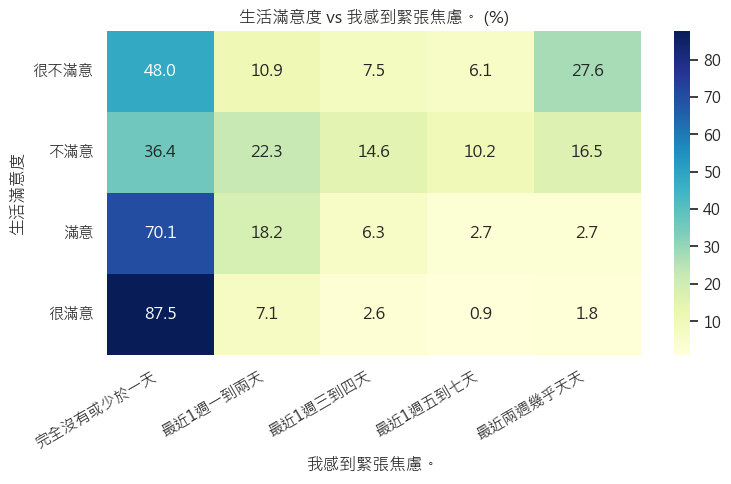

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

invalid_vals = ["系統遺漏值", "此卷未答", "拒答"]
target_col = "整體來說,你對自己的生活感到滿意嗎?_as62"
col = "我感到緊張焦慮。"

# 複製並過濾
df_tmp = df_s.copy()
df_tmp = df_tmp[~df_tmp[target_col].isin(invalid_vals)]
df_tmp = df_tmp[~df_tmp[col].isin(invalid_vals)]

# 計算交叉表並轉為百分比
ctab = pd.crosstab(df_tmp[target_col], df_tmp[col], normalize="index") * 100

# 重新排序列順序：很不滿意 → 不滿意 → 滿意 → 很滿意
new_order = ["很不滿意", "不滿意", "滿意", "很滿意"]
ctab = ctab.reindex(new_order)

# 繪製熱力圖
sns.set(style="whitegrid", font="Microsoft JhengHei")
plt.figure(figsize=(8, 5))
sns.heatmap(
    ctab,
    annot=True,
    fmt=".1f",
    cmap="YlGnBu"
)
plt.title("生活滿意度 vs 我感到緊張焦慮。 (%)")
plt.ylabel("生活滿意度")
plt.xlabel("我感到緊張焦慮。")
plt.xticks(rotation=30, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# 熱力圖：生活滿意度 vs 是否曾被網路霸凌

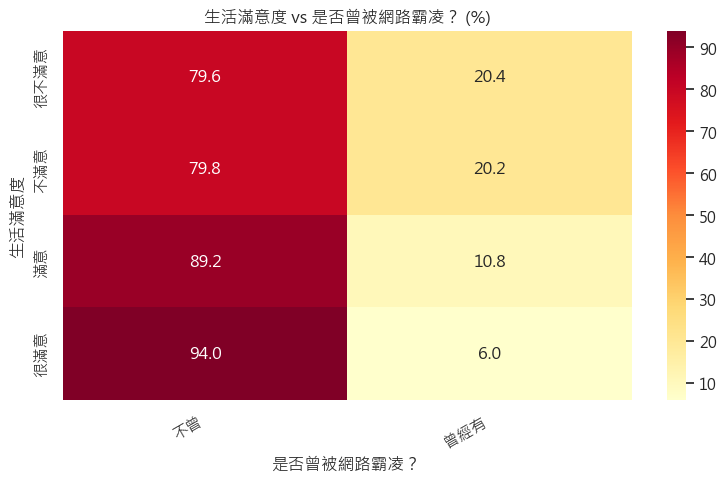

In [28]:
# Cell 2: 生活滿意度 vs 上七年級以來,你曾在網路上,被其他人辱罵、惡意取笑、拒絕加入討論、散布丟臉的影片、發布不實的訊息嗎?
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

invalid_vals = ["系統遺漏值", "此卷未答", "拒答"]
target_col = "整體來說,你對自己的生活感到滿意嗎?_as62"
col = "上七年級以來,你曾在網路上,被其他人辱罵、惡意取笑、拒絕加入討論、散布丟臉的影片、發布不實的訊息嗎?"

df_tmp = df_s.copy()
df_tmp = df_tmp[~df_tmp[target_col].isin(invalid_vals)]
df_tmp = df_tmp[~df_tmp[col].isin(invalid_vals)]
ctab = pd.crosstab(df_tmp[target_col], df_tmp[col], normalize="index") * 100

# 重新排序列順序：很不滿意 → 不滿意 → 滿意 → 很滿意
new_order = ["很不滿意", "不滿意", "滿意", "很滿意"]
ctab = ctab.reindex(new_order)

sns.set(style="whitegrid", font="Microsoft JhengHei")
plt.figure(figsize=(8, 5))
sns.heatmap(ctab, annot=True, fmt=".1f", cmap="YlOrRd")
plt.title("生活滿意度 vs 是否曾被網路霸凌？ (%)")
plt.ylabel("生活滿意度")
plt.xlabel("是否曾被網路霸凌？")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


# 熱力圖：生活滿意度 vs 家長成績要求

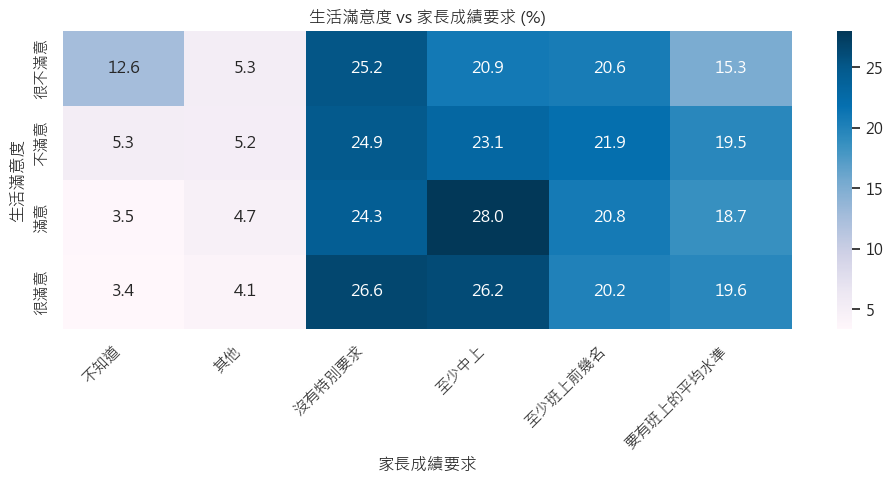

In [29]:
# Cell 3: 生活滿意度 vs 家長對你的學業成績有些甚麼要求?
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

invalid_vals = ["系統遺漏值", "此卷未答", "拒答"]
target_col = "整體來說,你對自己的生活感到滿意嗎?_as62"
col = "家長對你的學業成績有些甚麼要求?"

df_tmp = df_s.copy()
df_tmp = df_tmp[~df_tmp[target_col].isin(invalid_vals)]
df_tmp = df_tmp[~df_tmp[col].isin(invalid_vals)]
ctab = pd.crosstab(df_tmp[target_col], df_tmp[col], normalize="index") * 100

# 重新排序列順序：很不滿意 → 不滿意 → 滿意 → 很滿意
new_order = ["很不滿意", "不滿意", "滿意", "很滿意"]
ctab = ctab.reindex(new_order)

sns.set(style="whitegrid", font="Microsoft JhengHei")
plt.figure(figsize=(10, 5))
sns.heatmap(ctab, annot=True, fmt=".1f", cmap="PuBu")
plt.title("生活滿意度 vs 家長成績要求 (%)")
plt.ylabel("生活滿意度")
plt.xlabel("家長成績要求")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# 熱力圖：生活滿意度 vs 寂寞感

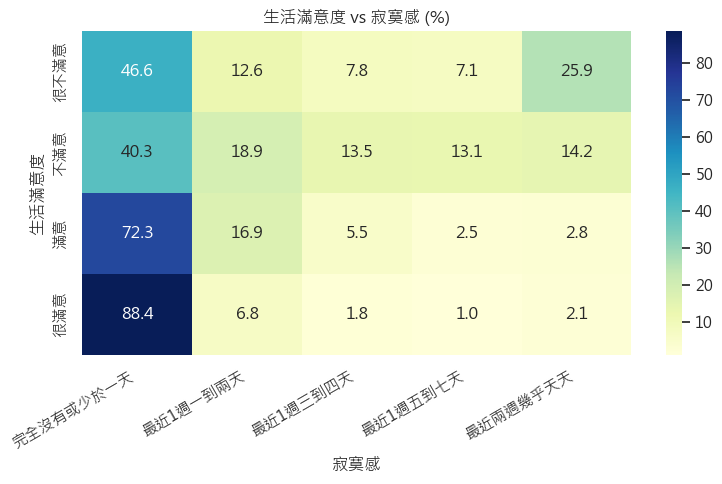

In [30]:
# Cell 4: 生活滿意度 vs 我覺得很寂寞(孤單、沒伴)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

invalid_vals = ["系統遺漏值", "此卷未答", "拒答"]
target_col = "整體來說,你對自己的生活感到滿意嗎?_as62"
col = "我覺得很寂寞(孤單、沒伴)"

df_tmp = df_s.copy()
df_tmp = df_tmp[~df_tmp[target_col].isin(invalid_vals)]
df_tmp = df_tmp[~df_tmp[col].isin(invalid_vals)]
ctab = pd.crosstab(df_tmp[target_col], df_tmp[col], normalize="index") * 100

# 重新排序列順序：很不滿意 → 不滿意 → 滿意 → 很滿意
new_order = ["很不滿意", "不滿意", "滿意", "很滿意"]
ctab = ctab.reindex(new_order)

sns.set(style="whitegrid", font="Microsoft JhengHei")
plt.figure(figsize=(8, 5))
sns.heatmap(ctab, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("生活滿意度 vs 寂寞感 (%)")
plt.ylabel("生活滿意度")
plt.xlabel("寂寞感")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


# 熱力圖：生活滿意度 vs 坐立不安

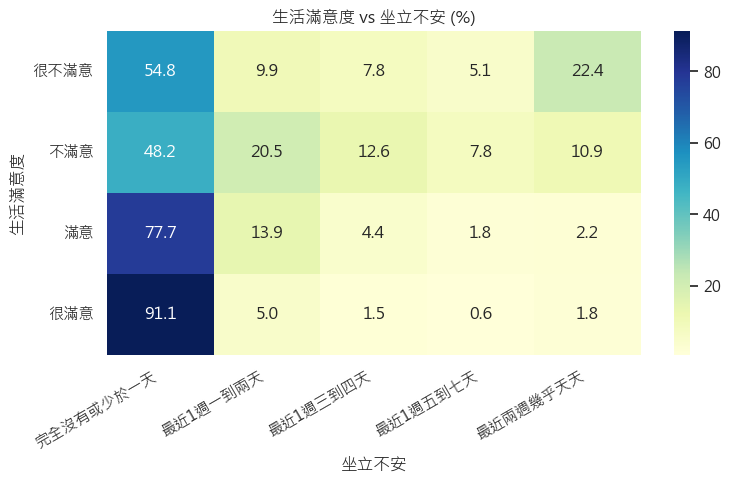

In [31]:
# Cell 5: 生活滿意度 vs 我覺得坐立不安
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

invalid_vals = ["系統遺漏值", "此卷未答", "拒答"]
target_col = "整體來說,你對自己的生活感到滿意嗎?_as62"
col = "我覺得坐立不安"

df_tmp = df_s.copy()
df_tmp = df_tmp[~df_tmp[target_col].isin(invalid_vals)]
df_tmp = df_tmp[~df_tmp[col].isin(invalid_vals)]
ctab = pd.crosstab(df_tmp[target_col], df_tmp[col], normalize="index") * 100

# 重新排序列順序：很不滿意 → 不滿意 → 滿意 → 很滿意
new_order = ["很不滿意", "不滿意", "滿意", "很滿意"]
ctab = ctab.reindex(new_order)

sns.set(style="whitegrid", font="Microsoft JhengHei")
plt.figure(figsize=(8, 5))
sns.heatmap(ctab, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("生活滿意度 vs 坐立不安 (%)")
plt.ylabel("生活滿意度")
plt.xlabel("坐立不安")
plt.xticks(rotation=30, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# 熱力圖：生活滿意度 vs 疲憊感

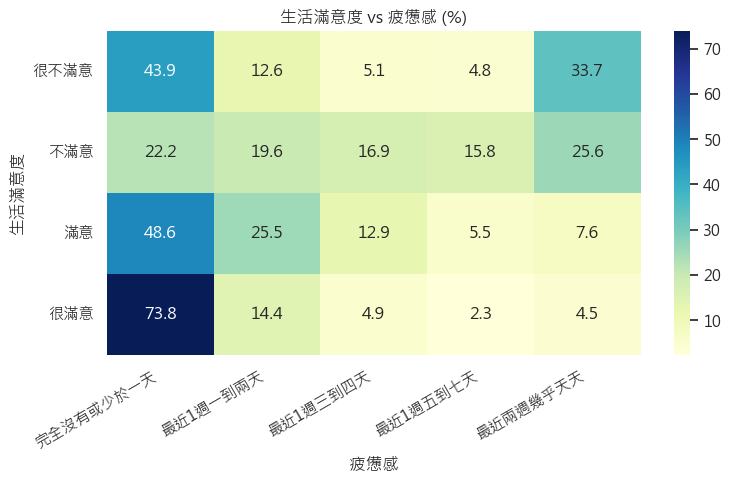

In [32]:
# Cell 6: 生活滿意度 vs 我總是感到疲憊。
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

invalid_vals = ["系統遺漏值", "此卷未答", "拒答"]
target_col = "整體來說,你對自己的生活感到滿意嗎?_as62"
col = "我總是感到疲憊。"

df_tmp = df_s.copy()
df_tmp = df_tmp[~df_tmp[target_col].isin(invalid_vals)]
df_tmp = df_tmp[~df_tmp[col].isin(invalid_vals)]
ctab = pd.crosstab(df_tmp[target_col], df_tmp[col], normalize="index") * 100

# 重新排序列順序：很不滿意 → 不滿意 → 滿意 → 很滿意
new_order = ["很不滿意", "不滿意", "滿意", "很滿意"]
ctab = ctab.reindex(new_order)

sns.set(style="whitegrid", font="Microsoft JhengHei")
plt.figure(figsize=(8, 5))
sns.heatmap(ctab, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("生活滿意度 vs 疲憊感 (%)")
plt.ylabel("生活滿意度")
plt.xlabel("疲憊感")
plt.xticks(rotation=30, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## 其他霸凌行為（網路 & 現實）文字雲分析

下面將針對兩欄開放式文字題：
1. 「其他霸凌行為(請說明)_as53a8」（網路霸凌補充）
2. 「其他霸凌行為(請說明):」（現實生活霸凌補充）

繪製文字雲（Word Cloud），字詞出現頻率越高，字體越大，以便快速了解學生填述的常見霸凌形式。


In [58]:
# 安裝 wordcloud
!pip install wordcloud


Defaulting to user installation because normal site-packages is not writeable


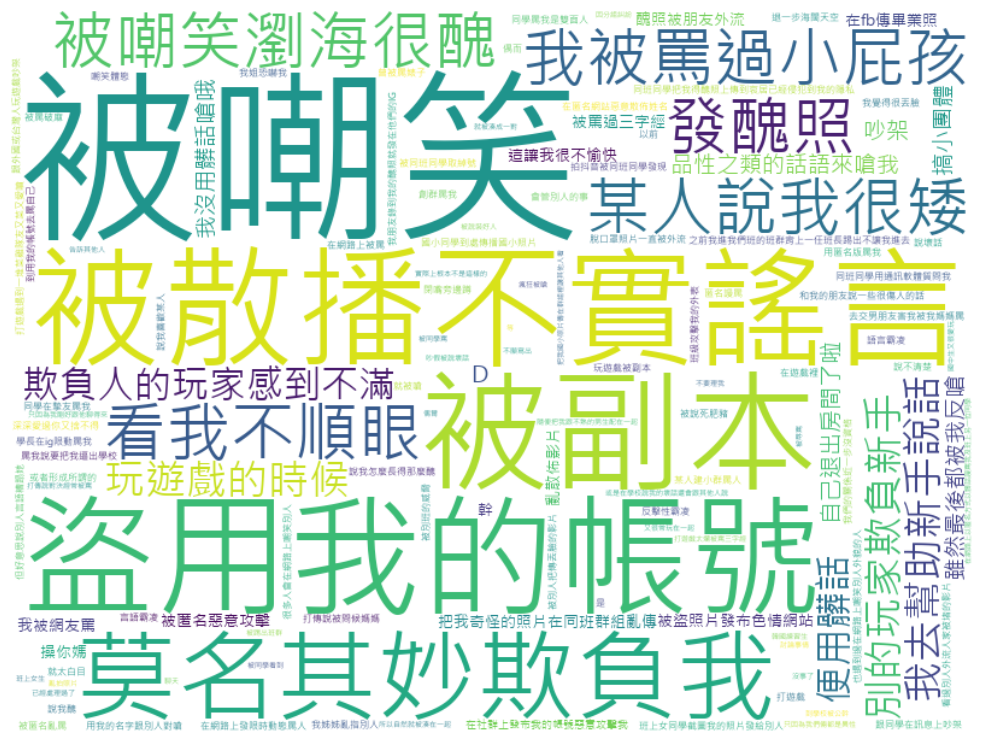

In [62]:
# 網路霸凌
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# 範例欄位名稱
col_net = "其他霸凌行為(請說明)_as53a8"

# 原始文字欄位（先 dropna、轉成字串）
texts_net = df_s[col_net].dropna().astype(str)

# 用正則同時篩掉只要「包含」以下關鍵詞的整筆
texts_net = texts_net[~texts_net.str.contains("跳答|無意義作答|拒答|系統遺漏值|無|有|不知道|不清楚忘記了")]

# 將剩下的文字合併
all_text_net = " ".join(texts_net)

# 準備停用詞
stopwords = set(STOPWORDS)

# 建立並繪製文字雲
wc_net = WordCloud(
    font_path="C:/Windows/Fonts/msjh.ttc",
    background_color="white",
    stopwords=stopwords,
    width=800,
    height=600,
    collocations=False
).generate(all_text_net)

plt.figure(figsize=(10, 8))
plt.imshow(wc_net, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()
plt.show()


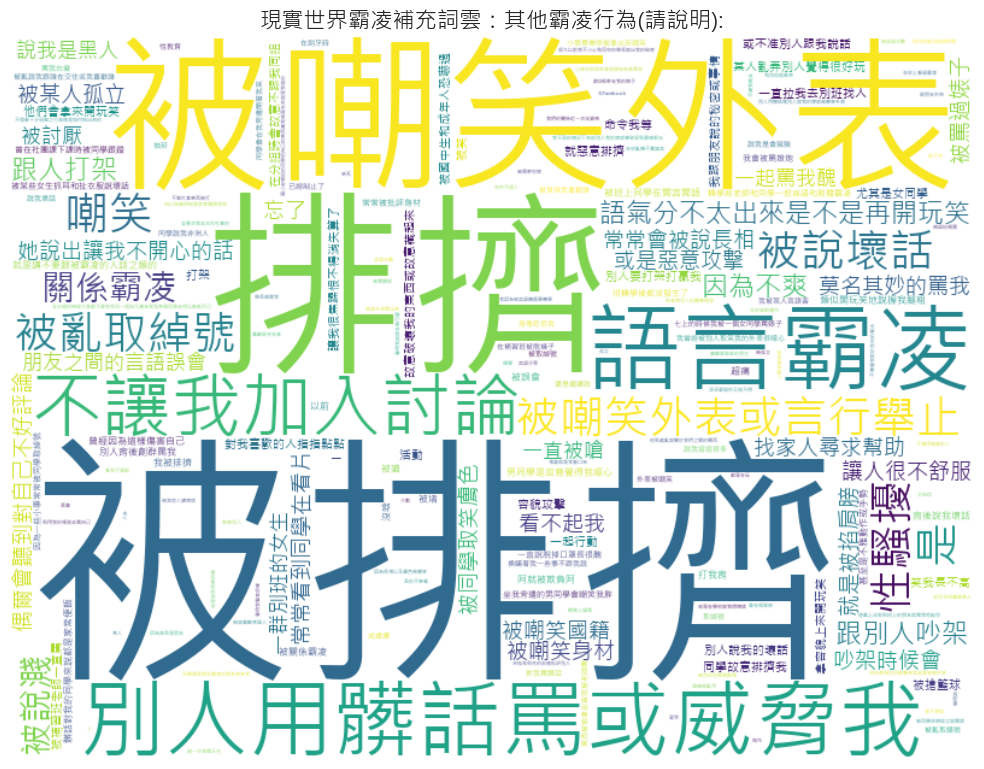

In [64]:
# 現實生活霸凌文字雲
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# 欄位名稱
col_real = "其他霸凌行為(請說明):"

# 原始文字欄位（先 dropna、轉成字串）
texts_real = df_s[col_real].dropna().astype(str)

# 用正則同時篩掉只要「包含」以下關鍵詞的整筆
texts_real = texts_real[~texts_real.str.contains("跳答|無意義作答|拒答|系統遺漏值|無|有|不知道|不清楚忘記了")]

# 將剩下的文字合併
all_text_real = " ".join(texts_real)

# 準備停用詞
stopwords = set(STOPWORDS)

# 使用微軟正黑體（Windows）
wc_real = WordCloud(
    font_path="C:/Windows/Fonts/msjh.ttc",
    background_color="white",
    stopwords=stopwords,
    width=800,
    height=600,
    collocations=False
).generate(all_text_real)

plt.figure(figsize=(10, 8))
plt.imshow(wc_real, interpolation="bilinear")
plt.axis("off")
plt.title("現實世界霸凌補充詞雲：其他霸凌行為(請說明):", fontsize=16)
plt.tight_layout()
plt.show()
